<a href="https://colab.research.google.com/github/agoniko/Electron-charge-estimation/blob/main/Physics_seminar_presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dataset values
---
The dataset used is from some students who conducted this experiment in the lab of Università degli studi di Milano. It contains values about the observations of 8 oil drops.
Each row of each observation contains the values of the passage of the oil drop on the relative reticle notch. There are 5 reticle notch. <br>
The observation values are:
*   Time from the start to the passage over the relevant reticle notchin the absence of an electric field
*   Time from the start to the passage over the relevant reticle notchin the presence of an electric field when the drop is falling
*   Time from the start to the passage over the relevant reticle notch in the presence of an electric field when the drop is rising
*   The Voltage of the generator
*   The temperature inside the chamber during that observation
*   Standard deviations of the first 3 values






## Defining constants
<center>
<img src="https://drive.google.com/uc?id=1PFiC-sJl7qmsvy6IwTw2KJGtsSYFFNXg" width = 300>
</center>



In [ ]:
#@title
#defining constants
dist = 5e-4
b = 8.2e-3
p = 101325
g = 9.806
diff = 858.707

#Oil drop Speed between reticle notches in presence of E
The oil drop speed in presence of an electrical field is calculated as the weighted average between the total spent time and the total space traveled for each interval between notches. This is done in order to reduce the uncertainty of the measurement.


# Speed in absence of E
In the absence of an electric field, the falling speeds of the droplet are calculated as before. Then, to obtain a single value of the initial speed, the uncertainties on the measurements are estimated by the method of partial derivatives.
<br>
<center>
<img src="https://drive.google.com/uc?id=1vCSfMbijZZLPi42V8FJvmpuz25CVL6q6">
</center>
Then, the initial speed is obtained as the weighted average of the speed of the oil drop between the reticle notches on their relative sigma.
<center>
<img src="https://drive.google.com/uc?id=11ZIJwdptVkIZxD6G6WIC07XpfI2J-q3I" width = "400">
</center>


# Defining radius function

<img src="https://drive.google.com/uc?id=1Xbu4SuUQbDBkoHj6n43V28LUW8eKhlyI" width = 350>


In [ ]:
#@title
def radius(dataset):
  eta = dataset['eta'][0]
  vr_list = dataset['v_ri']
  #riguarda calcolo raggio

  return np.mean([-b/(2*p) + np.sqrt(pow(b/(2*p),2) + ((9*eta*vr)/(2*g*diff))) for vr in vr_list])

#Defining charge function 
<img src="https://drive.google.com/uc?id=13L2RG0ToUlSC7wCJf2wP93hgH0n9fitR" width = 600>

In [ ]:
#@title

def charge1(v, vr, V, d, eta, r):
  if v > 0:
    q = -4 * np.pi * (r**3) * diff * g * (1 - abs(v) / vr) / (3 * V / d)
  else:
    q = -4 * np.pi * (r**3) * diff * g * (1 + abs(v) / vr) / (3 * (-V) / d)

  return q 



In [ ]:
#@title Data Preprocessing
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.interpolate import interp1d


creds, _ = default()
gc = gspread.authorize(creds)

def get_dataset(drop_number):
  #open dataset worksheet from G.drive
  worksheet = gc.open("dataset").get_worksheet(2)
  rows = worksheet.get_all_values()

  #split the drops experiments by -
  rows = rows[1:]
  indexes = [i for i in range(0,len(rows)) if rows[i][1] == '-']
  indexes.insert(0,0)
  indexes.append(len(rows))
  dataset = [rows[indexes[j]+1:indexes[j+1]] for j in range(0,len(indexes)-1)]
  dataset = pd.DataFrame.from_records(dataset[drop_number], columns = rows[0])

  #converting the dataframe's cells from string to floats
  dataset = pd.DataFrame([dataset[x].str.replace(',','.').astype(float) for x in dataset.columns])
  dataset = dataset.T



  #Compute absolute time from deltas
  dataset['t_f'] = dataset.dt_f
  dataset['t_r'] = dataset.dt_r
  dataset['t_vr1'] = dataset.t_vr

  for i in range(1,len(dataset)):
    dataset.t_vr1[i] = dataset.t_vr1[i-1]+dataset.t_vr1[i]

  
  dataset['v_ri'] = [dist/dataset.t_vr1[i]*(i+1) for i in range(0,len(dataset))]
  dataset['sd_vr'] = [np.sqrt(pow(dist * dataset['sd_tvr'][i] / pow(dataset['t_vr'][i],2),2) + pow(1e-5/dataset['t_vr'][i],2)) for i in range(0,len(dataset))]
  dataset['vr'] = [sum(dataset['v_ri']/ pow(dataset['sd_vr'],2)) / sum(1/pow(dataset['sd_vr'],2)) for i in range(0,len(dataset))]

  worksheet = gc.open("dataset").get_worksheet(3)
  rows = worksheet.get_all_values()

  R = float(rows[drop_number + 1][2].replace(',','.'))
  if drop_number > 1:
    T = (R - 2.053)/(2.0 - 2.053) + 24.0
  else:
    T = (R - 2.053)/(2.053 - 2.11) + 24.0
  dataset['eta'] = [((1.8+0.004765*(T-15))/100000) for i in range(0,len(dataset))]
  dataset['r'] = [radius(dataset) for i in range(0,len(dataset))]

  if drop_number == 7 or drop_number == 6:
    dataset = dataset[1:]
    dataset.index = np.arange(len(dataset))
  
  for i in range(1,len(dataset)):
    dataset.t_f[i] = dataset.t_f[i-1]+dataset.t_f[i]
    dataset.t_r[i] = dataset.t_r[i-1]+dataset.t_r[i]

  dataset['v_f'] = [(dist/dataset.t_f[i])*(i+1) for i in range(0,len(dataset))]
  dataset['v_r'] = [-(dist/dataset.t_r[i])*(i+1) for i in range(0,len(dataset))]


  dataset['V'] = [float(rows[drop_number + 1][0]) for i in range(0,len(dataset))]
  dataset['d'] = [float(rows[drop_number + 1][1].replace(',','.')) for i in range(0,len(dataset))]

  if drop_number == 1:
    dataset['Q_r'] = [charge1(dataset.v_r[i],dataset.vr[i],dataset.V[i]-1.0, dataset.d[i], dataset.eta[i], dataset.r[i]) for i in range(0,len(dataset))]
  else:
    dataset['Q_r'] = [charge1(dataset.v_r[i],dataset.vr[i],dataset.V[i], dataset.d[i], dataset.eta[i], dataset.r[i]) for i in range(0,len(dataset))]

  dataset['Q_f'] = [charge1(dataset.v_f[i],dataset.vr[i],dataset.V[i], dataset.d[i], dataset.eta[i], dataset.r[i]) for i in range(0,len(dataset))]

  return dataset

dataset = get_dataset(0)
dataset.loc[:,['t_vr', 'dt_f', 'dt_r', 't_f', 't_r', 'vr', 'eta', 'r', 'v_f', 'v_r', 'V','Q_r', 'Q_f']]

,t_vr,dt_f,dt_r,t_f,t_r,vr,eta,r,v_f,v_r,V,Q_r,Q_f
0,64.89,1.82,3.18,1.82,3.18,0.000007,0.000018,2.258044e-07,0.000275,-0.000157,553.0,1.309724e-19,2.135095e-19
1,74.26,1.62,2.70,3.44,5.88,0.000007,0.000018,2.258044e-07,0.000291,-0.000170,553.0,1.412084e-19,2.262473e-19
2,82.45,2.70,3.21,6.14,9.09,0.000007,0.000018,2.258044e-07,0.000244,-0.000165,553.0,1.371799e-19,1.892454e-19
3,69.46,2.54,3.16,8.68,12.25,0.000007,0.000018,2.258044e-07,0.000230,-0.000163,553.0,1.357833e-19,1.781723e-19
4,81.10,2.48,3.23,11.16,15.48,0.000007,0.000018,2.258044e-07,0.000224,-0.000161,553.0,1.343745e-19,1.730681e-19


#Estimate K value of each charge using the MSE function
We now want to estimate an integer number (Ki) of elementary charges, electrons, on each of the drops. To determine this integer number we need to know a rough estimate of the electron charge, which is estimated as the value that minimize the mean squared error introduced by the formula:
<center><img src="https://drive.google.com/uc?id=1UU400fvJ8CtgJaMgr435NK-X4IAsN_Yl " width = "250"></center>
Where Qi represents the total charge present on each drop and ki(q) is defined as follows:

<center><img src="https://drive.google.com/uc?id=1ySHXVj1WsobEbbstoN9EUu2a6qu7Wb1B" width = "200"></center>

q is then made to vary within an interval identified as [1.5E-19 C, 1.7E-19 C] with a single step of 0.001e-19 C in order to find that value of q that would minimize the function S(q)
<br>
<br>

100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


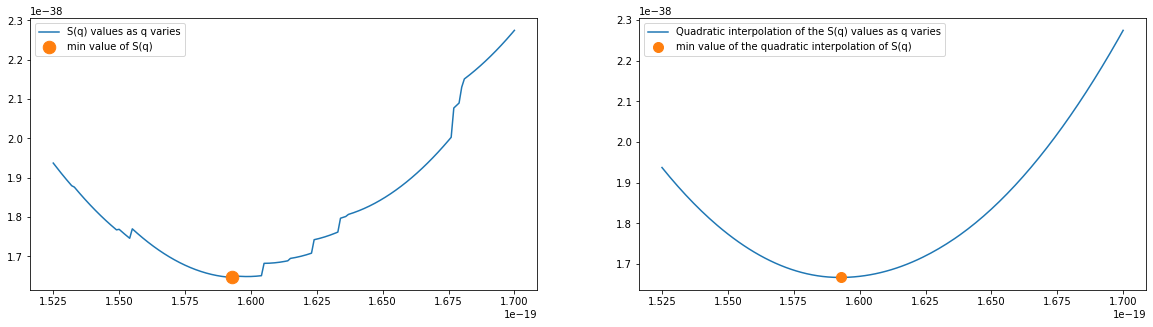

The value q that minimize the S(q) function is: 1.593e-19 C


In [ ]:
#@title Now we perform this process on the data obtained from all observations:
import math
def get_k(Qi,q):
  return math.trunc(Qi/q + 0.5)

def Sq(Q,q):
  return sum([((qi/get_k(qi,q)) - q)**2 for qi in Q])
  
indexes = np.arange(8)
frames = []
for i in tqdm(indexes):
  dataset = get_dataset(i)
  frames.append(dataset)
 
all_values = pd.concat(frames)
all_values.index = np.arange(len(all_values))

charges = np.array(list(all_values.Q_f.tolist() + all_values.Q_r.tolist()))
xrange = np.arange(1.525e-19, 1.7e-19, 0.001e-19)
Ks = set([get_k(x,y) for x in charges for y in xrange])
S = [Sq(charges,x) for x in xrange]
e = min(xrange[np.where(S==min(S))])

#create interpolation of the S(q) curve
x = np.linspace(1.525e-19, 1.7e-19, 5)
S_inter = [Sq(charges,xi) for xi in x]
f1 = interp1d(x, S_inter, kind = 'quadratic')
x_new = np.linspace(1.525e-19, 1.7e-19, 176)
rounded_e = x_new[np.where(f1(x_new) == min(f1(x_new)))]



f, ax = plt.subplots(1,2,figsize = (20,5))
ax[0].plot(xrange, S, '-', e ,min(S),'.',markersize=25)
ax[0].legend(["S(q) values as q varies","min value of S(q)"])

ax[1].plot(x_new, f1(x_new),rounded_e, min(f1(x_new)),'.', markersize = 20)
ax[1].legend(["Quadratic interpolation of the S(q) values as q varies","min value of the quadratic interpolation of S(q)"])

plt.show()
print("The value q that minimize the S(q) function is:", str(round(e,22)) + " C")
#lo scarto q.m. dovrebbe essere una parabola, qui ho il salti dovuti al troncamento al valore intero di K

#Charges clustered around their K value
Once we have found q, we calculate the K value of each charge by dividing each charge by q.<br>
The following histogram takes some sample charges and devides them by the q value estimated, we can see that the charges are then clustered around their K value.

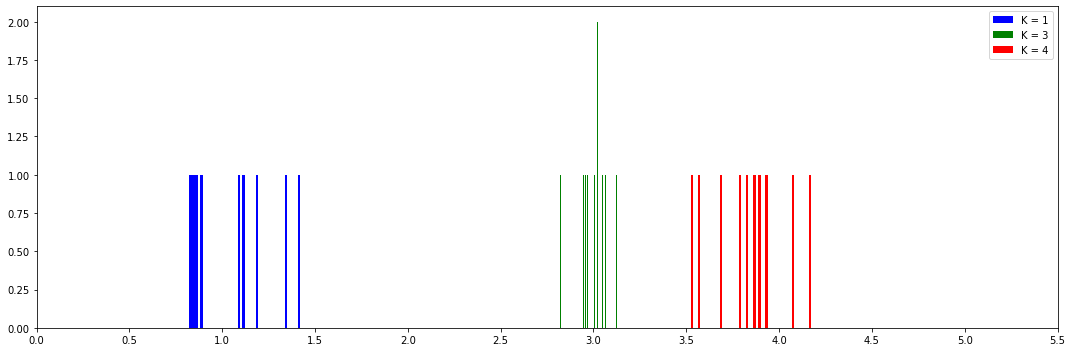

In [ ]:
#@title
f, ax = plt.subplots(figsize=(15, 5),sharey=True, tight_layout=True)
xrange = np.arange(1.525e-19, 1.7e-19, 0.001e-19)
cont = 0
colors = ["blue", "green", "red", "cyan", "magenta", "yellow", "black"]
qe = []
K = []
indexes = [0,3,4]
cont = 0
charges = []
for i in indexes:
  charges.append(np.array(list(frames[i].Q_f.tolist() + frames[i].Q_r.tolist())))

charges = np.array([x[i] for x in charges for i in range(0,len(x))])

S = [Sq(charges,x) for x in xrange]
print()
Ks = [get_k(x,e) for x in charges]
K.append(Ks)
qe.append(charges)

unique_K = np.array(list(set(Ks)))
l = []
for k in range(0,len(unique_K)):
  ax.hist(charges[np.where(Ks == unique_K[k])]/e , color = colors[k], bins = 50)
  ax.set(xticks=np.arange(0,6,.5))
  l.append("K = " + str(unique_K[k]))

ax.legend(l)
cont+=1

for cont in np.arange(8):
  charges = np.array(list(frames[cont].Q_f.tolist() + frames[cont].Q_r.tolist()))
  S = [Sq(charges,x) for x in xrange]
  Ks = [get_k(x,e) for x in charges]
  K.append(Ks)
  qe.append(charges)

K = [x[i] for x in K for i in range(0,len(x))]
qe = [x[i] for x in qe for i in range(0,len(x))]

#Results
Estimates for each elementary charge are obtained by dividing the Qi estimated in the previous step by the corresponding value of Ki.<br>
As the best estimate of e I took the average of the quantities just illustrated, while as uncertainty I took the standard deviation on the mean of the sample of measurements.

The estimated value for e is 1.595e-19 C with a s.d. of 0.02e-19 C with a relative uncertainty of 1.058% and 0.466σ away from the accepted expected value (2004 measurement) of 1.60217653(14)E-19 C.

In [ ]:
#@title
mu = 1.60217653E-19
q = [qe[i]/K[i] for i in range(0,len(qe))]
std = (np.std(q)/np.sqrt(len(q)))
print("Uncertainty: "+str(round(std / np.mean(q)*100,3)) + "%")
print("Distance from expected value: "+str(round((mu - np.mean(q))/std,3))+ "σ")


Uncertainty: 1.013%
Distance from expected value: 0.466σ
